In [114]:
import numpy as np
import matplotlib.pyplot as plt

### Functions

In [115]:
def one_step_forward(x,weights,vor):
    num_of_exps=len(weights[0])
    exped=np.zeros((len(x),num_of_exps))
    predictions=np.zeros((len(x),1))
    for i in range(num_of_exps):
        exped[:,i]=np.exp(vor[0,i]*x).reshape(-1)
        predictions[:,0]+=weights[0,i]*exped[:,i]
    y_hat=np.sum(predictions,axis=1)

    return exped,y_hat

In [116]:
def loss(y,y_hat):
    return (1/len(y))*np.sum(np.power((y-y_hat),2))

In [117]:
def one_step_backward(num_of_exps,weights,x,exped,y_hat,y):
    dvor=np.zeros((len(x),num_of_exps))
    dweights=np.zeros((len(x),num_of_exps))
    for i in range(num_of_exps):
        dvor[:,i]=(-2*(y-y_hat))*weights[0,i]*exped[:,i]*x[:,0]
        dweights[:,i]=(-2*(y-y_hat))*exped[:,i]
    dv=(1/len(x))*np.sum(dvor,axis=0)
    dw=(1/len(x))*np.sum(dweights,axis=0)
    return dw,dv

In [118]:
def update(weights,vor,dw,dv,step,coef):
    weights[0,:]=weights[0,:]-coef*dw
    vor[0,:]=vor[0,:]-coef*dv
    return weights,vor

In [119]:
def initialize(num_of_exps):
    weights=np.random.random((1,num_of_exps))
    vor=np.random.random((1,num_of_exps))
    return weights,vor

In [120]:
def utility(x,weights,vor):
    res=np.zeros(len(x))
    for i in range(len(weights)):
        res+=weights[i]*np.exp(x*vor[i])
    return res

In [121]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

## Gradient Descent


In [122]:
def gradient_descent(num_of_exps, max_iteration, step_coeff):

    weights,vor=initialize(num_of_exps)
    losses=[]
    for i in range(max_iteration):
        exped,y_hat=one_step_forward(x,weights,vor)
        l=loss(y,y_hat)
        losses.append(l)
        dw,dv=one_step_backward(num_of_exps,weights,x,exped,y_hat,y)
        #print(dw,dv)
        #if i==1000:
        #    step_coeff=step_coeff*10
        #if i==10000:
        #    step_coeff=step_coeff*10
        #if i==100000:
        #    step_coeff=step_coeff*10
        weights,vor=update(weights,vor,dw,dv,i,step_coeff)
    
    return weights,vor,losses
   

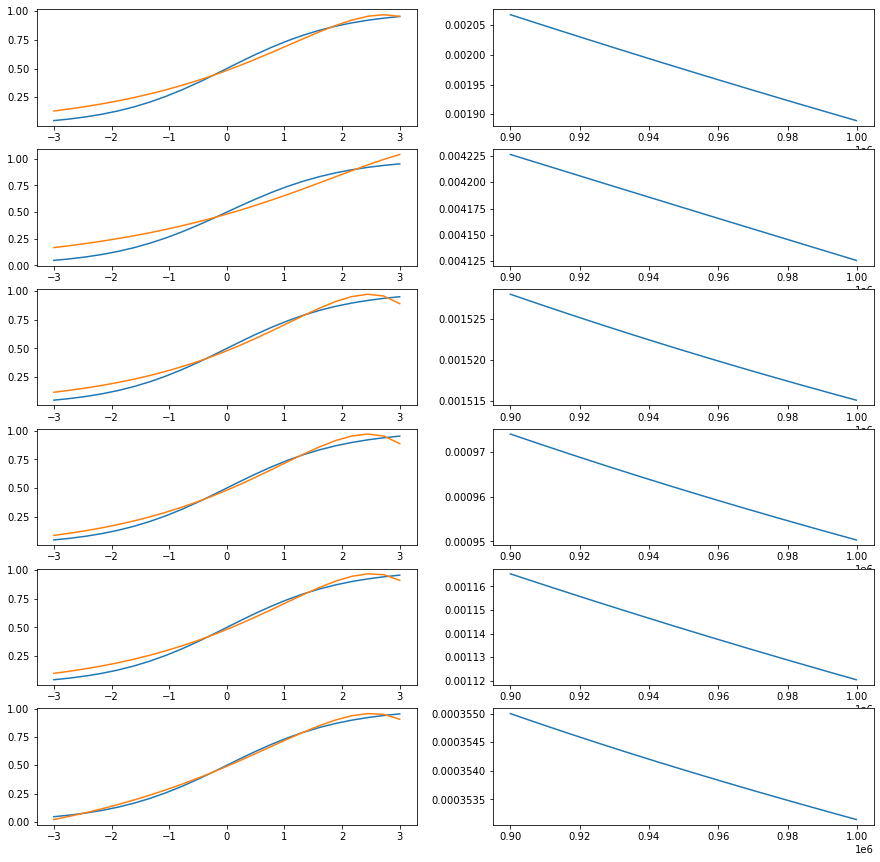

In [41]:
#x = np.linspace(-3, 3, 100) 
b=3
n=40

p1=np.linspace(-b,-0.5,int(n/4))
p2=np.linspace(-0.5,0.5,int(n/2))
p3=np.linspace(0.5,b,int(n/4))
x=np.hstack([p1,p2,p3])

y=sigmoid(x)
x=x.reshape(len(x),1)
max_iteration=1000000

weights=[]
vors=[]
losses=[]
fig, ax=plt.subplots(6,2,figsize=(15,15))
for i,n in enumerate([5,6,7,8,9,10]):
    w,v,l=gradient_descent(num_of_exps=n, max_iteration=max_iteration, step_coeff=1e-5)
    weights.append(w.reshape(-1))
    vors.append(v.reshape(-1))
    losses.append(l)
    
    x2=x.reshape(-1)
    y_hat=utility(x2,weights[i],vors[i])
    
    ax[i][0].plot(x2,y)
    ax[i][0].plot(x2,y_hat)
    
    iteration=np.arange(0,max_iteration,100)
    ls=np.array(losses[i])[iteration]
    ax[i][1].plot(iteration[-1000:-1],ls[-1000:-1])

# Extended version


In [128]:
def one_step_forward_with_moments(x,weights,vor):
    num_of_exps=len(weights[0])
    exped=np.zeros((len(x),num_of_exps))
    b_exped=np.zeros((len(x),num_of_exps))
    b2_exped=np.zeros((len(x),num_of_exps))
    
    predictions=np.zeros((len(x),1))
    d_predictions=np.zeros((len(x),1))
    d2_predictions=np.zeros((len(x),1))
    
    for i in range(num_of_exps):
        exped[:,i]=np.exp(vor[0,i]*x).reshape(-1)
        b_exped[:,i]=vor[0,i]*exped[:,i]
        b2_exped[:,i]=np.power(vor[0,i],2)*exped[:,i]
        
        predictions[:,0]+=weights[0,i]*exped[:,i]
        d_predictions[:,0]+=weights[0,i]*b_exped[:,i]
        d2_predictions[:,0]+=weights[0,i]*b2_exped[:,i]
    #     
    y_hat=np.sum(predictions,axis=1)
    #
    dyhat_dx=np.sum(d_predictions,axis=1)
    dy_dx=np.exp(-x)/np.power((np.exp(-x)+1),2)
    #
    d2yhat_dx=np.sum(d2_predictions,axis=1)
    d2y_dx=-1*np.exp(-1*x)/np.power((1+np.exp(-1*x)),3)
    
    return exped,y_hat, b_exped,dyhat_dx,dy_dx,b2_exped,d2yhat_dx,d2y_dx

In [129]:
def loss_with_moments(y,y_hat,dy_dx,dyhat_dx, d_coeff,d2y_dx,d2yhat_dx,d2_coeff):
    l1=(1/len(y))*np.sum(np.power((y-y_hat),2))
    l2=(1/len(y))*np.sum(np.power((dy_dx-dyhat_dx),2))
    l3=(1/len(y))*np.sum(np.power((d2y_dx-d2yhat_dx),2))
    return l1+d_coeff*l2 + d2_coeff*l3

In [139]:
def one_step_backward_with_moments(num_of_exps,weights,x,exped,y_hat,y,b_exped,dyhat_dx,dy_dx,d_coeff,b2_exped,d2yhat_dx,d2y_dx,d2_coeff):
    # final derivatives
    dvor=np.zeros((len(x),num_of_exps))
    dweights=np.zeros((len(x),num_of_exps))
    
    # for first and second derivatives
    dx_diff=dy_dx.reshape(len(x),1) -dyhat_dx.reshape(len(x),1)
    d2x_diff=d2y_dx.reshape(len(x),1) -d2yhat_dx.reshape(len(x),1)
    
    for i in range(num_of_exps):
        # y- part
        m0_vor=(-2*(y-y_hat))*weights[0,i]*exped[:,i]*x[:,0]
        m0_weight=(-2*(y-y_hat))*exped[:,i]
        
        # first derivative
        m1_vor=2*dx_diff*((-1)*weights[0,i]*(exped[:,i]+b_exped[:,i]*x[:,0])).reshape(len(x),1)
        m1_weight=2*dx_diff*((-1)*b_exped[:,i]).reshape(len(x),1)
        
        # Second derivative
        m2_vor=2*d2x_diff*((-1)*weights[0,i]*(2*b_exped[:,i]+b2_exped[:,i]*x[:,0])).reshape(len(x),1)
        m2_weight=2*dx_diff*((-1)*b2_exped[:,i]).reshape(len(x),1)
        
        # sum of all derivative parts
        dvor[:,i]= m0_vor + (d_coeff*m1_vor).reshape(-1) + (d2_coeff*m2_vor).reshape(-1)        
        dweights[:,i]= m0_weight + (d_coeff*m1_weight).reshape(-1) + (d2_coeff*m2_weight).reshape(-1)
        
    dv=(1/len(x))*np.sum(dvor,axis=0)
    dw=(1/len(x))*np.sum(dweights,axis=0)
    return dw,dv

In [140]:
def gradient_descent_with_moments(num_of_exps, max_iteration, step_coeff,d_coeff,d2_coeff):

    weights,vor=initialize(num_of_exps)
    losses=[]
    for i in range(max_iteration):
        exped,y_hat, b_exped,dyhat_dx,dy_dx,b2_exped,d2yhat_dx,d2y_dx=one_step_forward_with_moments(x,weights,vor)
        l=loss_with_moments(y,y_hat,dy_dx,dyhat_dx, d_coeff,d2y_dx,d2yhat_dx,d2_coeff)
        losses.append(l)
        dw,dv=one_step_backward_with_moments(num_of_exps,weights,x,exped,y_hat,y,b_exped,dyhat_dx,dy_dx,d_coeff,b2_exped,d2yhat_dx,d2y_dx,d2_coeff)
        #print(dw,dv)
        #if i==1000:
        #    step_coeff=step_coeff*10
        #if i==10000:
        #    step_coeff=step_coeff*10
        #if i==100000:
        #    step_coeff=step_coeff*10
        weights,vor=update(weights,vor,dw,dv,i,step_coeff)
    
    return weights,vor,losses

## Gradient Descent with first and second derivatives

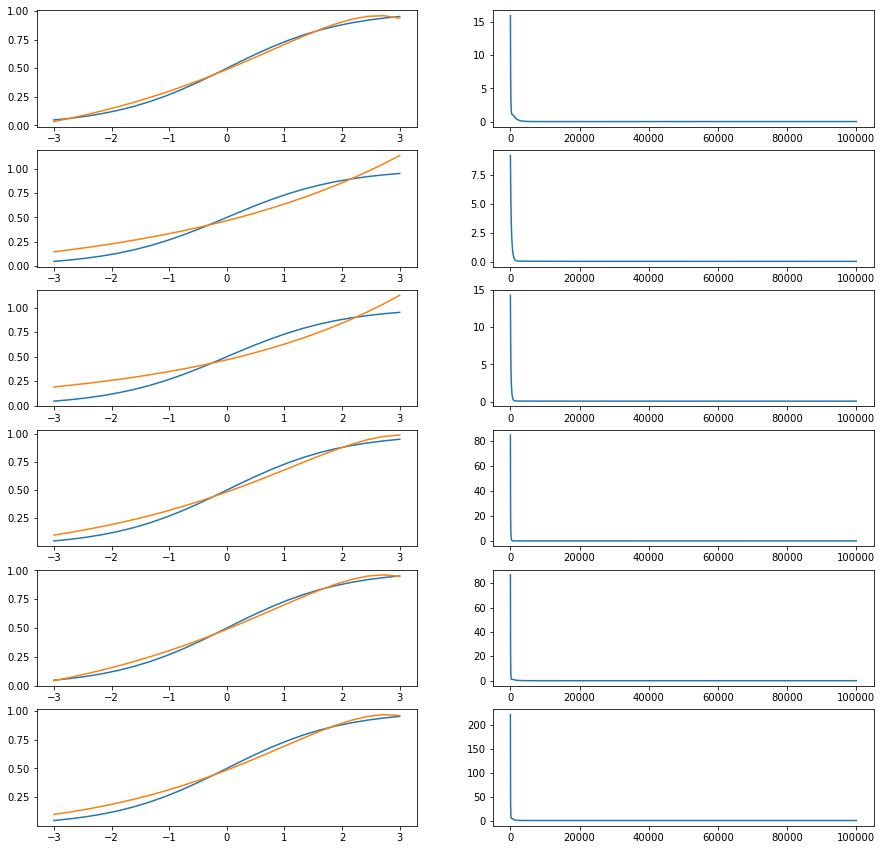

In [143]:
#x = np.linspace(-3, 3, 100) 
b=3
n=40
co1=2
co2=1

p1=np.linspace(-b,-0.5,int(n/4))
p2=np.linspace(-0.5,0.5,int(n/2))
p3=np.linspace(0.5,b,int(n/4))
x=np.hstack([p1,p2,p3])

y=sigmoid(x)
x=x.reshape(len(x),1)
max_iteration=100000

d_coeff=co1/n
d2_coeff=co2/n

weights=[]
vors=[]
losses=[]
fig, ax=plt.subplots(6,2,figsize=(15,15))
for i,n in enumerate([5,6,7,8,9,10]):
    w,v,l=gradient_descent_with_moments(num_of_exps=n, max_iteration=max_iteration, step_coeff=1e-4,d_coeff=d_coeff,d2_coeff=d2_coeff)
    weights.append(w.reshape(-1))
    vors.append(v.reshape(-1))
    losses.append(l)
    
    x2=x.reshape(-1)
    y_hat=utility(x2,weights[i],vors[i])
    
    ax[i][0].plot(x2,y)
    ax[i][0].plot(x2,y_hat)
    
    iteration=np.arange(0,max_iteration,100)
    ls=np.array(losses[i])[iteration]
    ax[i][1].plot(iteration,ls)